# **0. 패키지 로딩**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
np.set_printoptions(suppress = True)

# **1. 데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 현재 매장은 `type`에 따라 5개로 구분되어있는 상태
  - typeA, typeB, typeC, typeD, typeE
  


In [ ]:
## 파일 상위 경로 설정
# 본인 경로에 맞게 수정 필요(작업하는 곳에 공유 드라이브 바로가기 해두면 편함)

train_path = '/content/drive/MyDrive/Colab Notebooks/ESAA 학회_OB/esaa OB 3조/방학프로젝트/data/modeling/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/ESAA 학회_OB/esaa OB 3조/방학프로젝트/data/modeling/val'
test_path = '/content/drive/MyDrive/Colab Notebooks/ESAA 학회_OB/esaa OB 3조/방학프로젝트/data/modeling/test'

In [ ]:
# 데이터 파일 경로 저장
train_files = [os.path.join(train_path, f'train{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]
val_files = [os.path.join(val_path, f'val{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]
test_files = [os.path.join(test_path, f'test{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]

# 각 파일을 데이터프레임 형태로 불러오기
train_types = [pd.read_csv(file) for file in train_files]
val_types = [pd.read_csv(file) for file in val_files]
test_types = [pd.read_csv(file) for file in test_files]

In [ ]:
### 데이터 확인

# **2. 평가 지표**
- Root Mean Squared Logarithmic Error(`RMSLE`)
  - 다음과 같이 계산  
  $ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $
  - $n$: 총 인스턴스 수
  - $ \hat{y}_i$: 인스턴스 $i$에 대한 타겟의 예측값
  - $y_i$: 인스턴스 $i$에 대한 타겟의 실제값

In [ ]:
from sklearn.metrics import mean_squared_log_error

### RMSLE 계산
def rmsle(y, pred):
  # 오버플로, 언더플로 방지를 위해 log1p()로 로그 변환
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)

  squared_error = (log_y - log_pred) ** 2

  rmsle = np.sqrt(np.mean(squared_error))

  return rmsle

# **3. 모델별 성능 확인을 위한 함수**

In [ ]:
colors = [
    'khaki', 'teal', 'orchid', 'sandybrown', 'greenyellow', 'dodgerblue', 'rosybrown',
    'deeppink', 'salmon', 'olivedrab', 'olive', 'forestgreen',
    'royalblue', 'mediumpurple', 'gold', 'seagreen',
    'turquoise', 'steelblue', 'slategray', 'peru', 'slateblue', 'cadetblue',
    'lime', 'lavender', 'lightcoral', 'lightseagreen', 'lightskyblue', 'lightgreen',
    'lightpink', 'lightsalmon', 'lightsteelblue', 'lightyellow', 'palegreen',
]

In [ ]:
## 회귀곡선 시각화
# 예측값, 실제값을 산점도로 표현

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='b')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

In [ ]:
def model_eval(name_, pred, actual):
    global my_predictions
    global colors

    plot_predictions(name_, pred, actual)

    rmsle = np.sqrt(mean_squared_log_error(actual, pred))

    my_predictions[name_] = {'rmsle': rmsle}

    # 데이터프레임 생성
    df = pd.DataFrame(my_predictions).T
    df['model'] = df.index
    df = df.sort_values(by=['rmsle'], ascending=[True])

    # 상한, 하한 설정
    min_ = df['rmsle'].min() - 0.1
    max_ = df['rmsle'].max() + 0.1

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['rmsle'])

    for i, v in enumerate(df['rmsle']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 0.02, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('RMSLE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()

    print()
    print(df)

In [ ]:
# 모델의 중요도 상위 10개의 피처명과 그때의 중요도 값을 Series로 반환

def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
    ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]
    return ftr_top10

def visualize_ftr_importances(model):
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.tight_layout()

    ftr_top10 = get_top_features(model)
    ax.set_title(model.__class__.__name__ + ' Feature Importances', size=15)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

    sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax)

# **4. 모델링**

## **🏪 Type A**

In [ ]:
trainA = train_types[0]
valA = val_types[0]
testA = test_types[0]

In [ ]:
# trainA = pd.read_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train/trainA.csv')
# valA = pd.read_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val/valA.csv')
# testA = pd.read_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/test/testA.csv')

In [ ]:
trainA.head()

,sales,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,9.104758,3.355491,-1.025047,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,5.723585,-0.544403,1.190046,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,7.003974,-0.544403,1.588964,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,7.289877,3.004131,-0.881090,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,8.633909,-0.544403,1.728982,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
trainA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250486 entries, 0 to 250485
Data columns (total 84 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   sales                              250486 non-null  float64
 1   onpromotion                        250486 non-null  float64
 2   dcoilwtico                         250486 non-null  float64
 3   store_nbr_44                       250486 non-null  int64  
 4   store_nbr_45                       250486 non-null  int64  
 5   store_nbr_46                       250486 non-null  int64  
 6   store_nbr_47                       250486 non-null  int64  
 7   store_nbr_48                       250486 non-null  int64  
 8   store_nbr_49                       250486 non-null  int64  
 9   store_nbr_50                       250486 non-null  int64  
 10  store_nbr_51                       250486 non-null  int64  
 11  store_nbr_52                       2504

In [ ]:
valA.head()

,sales,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,27.000,0.105579,-0.468095,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,617.000,1.405544,-0.899535,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,255.081,0.755561,-0.496725,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,597.000,2.705508,-0.689414,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,201.000,-0.544403,-0.769613,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
testA.head()

,id,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,...,month_5,month_6,month_7,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_4
0,3002142,-0.544403,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3002143,-0.544403,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3002144,0.485794,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3002145,2.435741,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3002146,-0.544403,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**데이터 준비**

In [ ]:
## Feature vs Target

X_train = trainA.drop('sales', axis=1)
y_train = trainA['sales']

X_val = valA.drop('sales', axis=1)
y_val = valA['sales']

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(250486, 83) (250486,)
(107352, 83) (107352,)


In [ ]:
X_test = testA.drop(['id', 'family_BABY CARE'], axis = 1) # train 데이터에는 해당 정보가 x

In [ ]:
X_test.shape

(4752, 83)

### **4-1. Base Model**

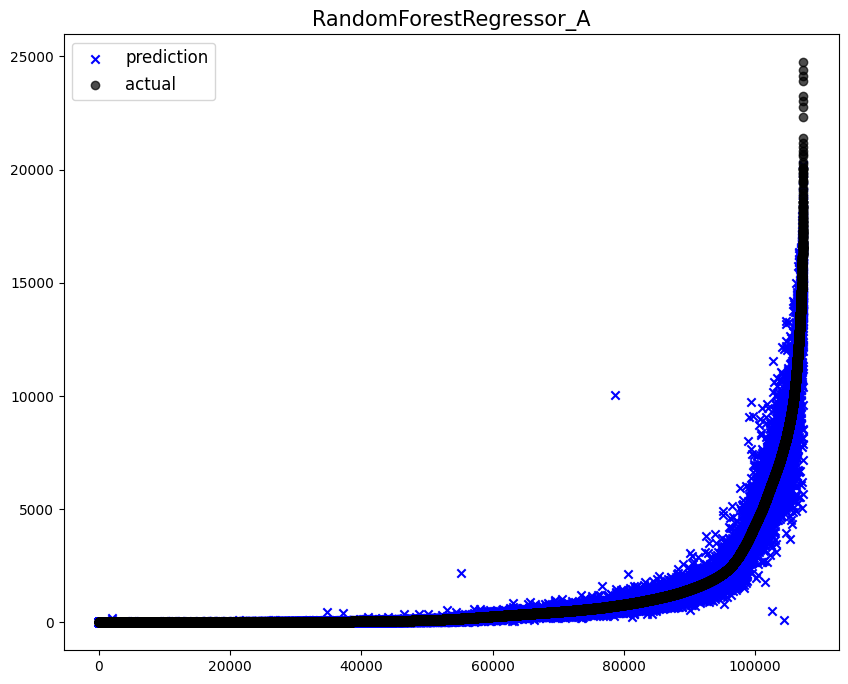

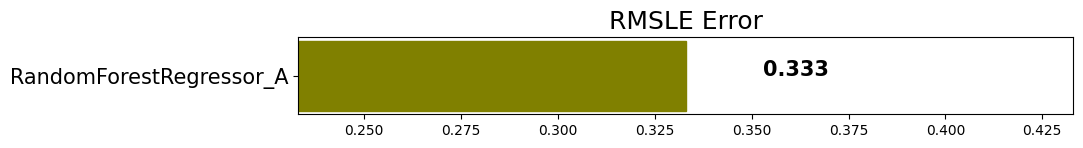


                            rmsle                    model
RandomForestRegressor_A  0.332977  RandomForestRegressor_A


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_baseA = RandomForestRegressor(n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_baseA.fit(X_train, y_train)

# 모델 예측
rf_predA = rf_baseA.predict(X_val)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predA = np.expm1(rf_predA)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_A', original_rf_predA, y_val)

### **4-2. 하이퍼 파라미터 튜닝**


#### **HyperOpt**
- 베이지안 최적화 알고리즘을 활용하여 효율적인 하이퍼파라미터 최적화를 제공하는 파이썬 라이브러리
  - 이를 통해 사용자는 자동화된 최적화, 다양한 최적화 알고리즘 선택, 고급 최적화 알고리즘 활용 등을 통해 모델 성능을 향상시킬 수 있음
- **주요 로직**
  1. 입력 변수명과 입력값의 검색 공간 설정
  2. 목적 함수 설정
  3. 목적 함수의 반환 최솟값을 가지는 최적 입력값 유추
- 참고자료  
  [베이지안 최적화에 기반한 HyperOpt를 활용한 하이퍼 파라미터 튜닝](https://teddylee777.github.io/machine-learning/hyper-opt/)

In [ ]:
# !pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import STATUS_OK

In [ ]:
## 검색 공간 설정

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)), # 트리 개수
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]), # 트리의 최대 깊이
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)), # 노드 분할을 위한 최소 샘플 수
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)), # 리프 노드를 위한 최소 샘플 수
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']) # 트리 분할 시 사용할 최대 특성의 수
}

In [ ]:
## 목적 함수 설정

def objective(params):
  model = RandomForestRegressor(**params)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)
  y_pred = np.expm1(y_pred) # 원래 스케일로 원복

  rmsle_val = rmsle(y_val, y_pred)

  return {'loss': rmsle_val, 'status': STATUS_OK}

In [ ]:
## 파라미터 최적화 수행

trials = Trials()
best = fmin(fn = objective, # 목적 함수
            space = space, # 탐색 공간
            algo = tpe.suggest, # 최적화 적용 알고리즘
            max_evals = 30,  # 최대 반복 횟수
            trials = trials, # 최적값 반환
            rstate = np.random.default_rng(seed = 0)) # seed 설정
print(best)

100%|██████████| 30/30 [2:00:31<00:00, 241.04s/trial, best loss: 0.32304888052749414]
{'max_depth': 0, 'max_features': 0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 130}


- 하이퍼 파라미터 튜닝을 진행한 **model**의 성능이 더 좋다.

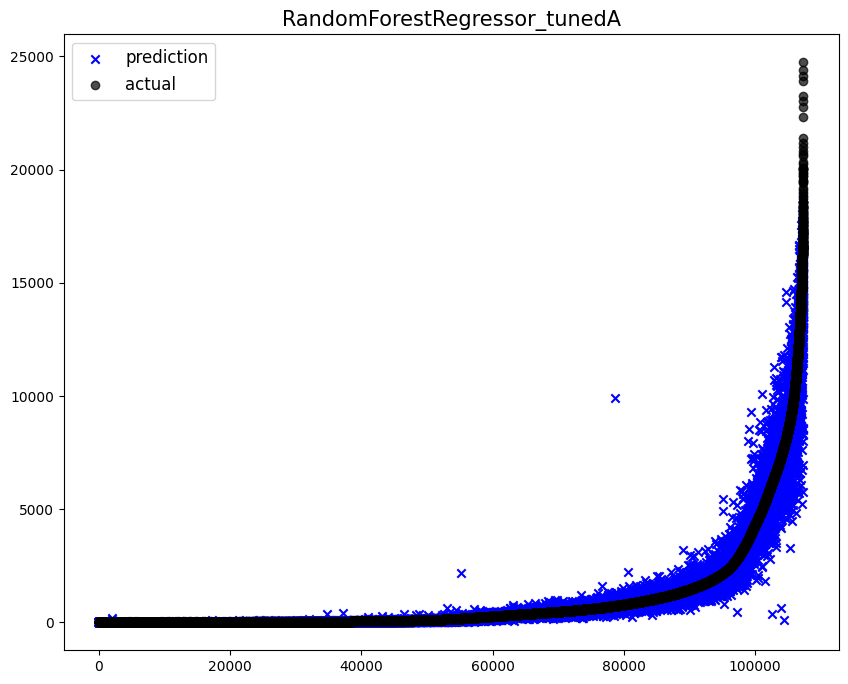

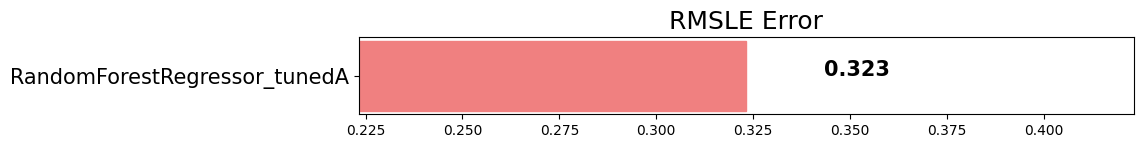


                                 rmsle                         model
RandomForestRegressor_tunedA  0.323226  RandomForestRegressor_tunedA


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 최적 모델 생성
rf_tunedA = RandomForestRegressor(max_depth = None, max_features = None, min_samples_leaf = 4,
                                  min_samples_split = 2, n_estimators = 130,
                                  n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_tunedA.fit(X_train, y_train)

# 모델 예측
rf_predA = rf_tunedA.predict(X_val)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predA = np.expm1(rf_predA)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_tunedA', original_rf_predA, y_val)

In [ ]:
### 모델 저장

import pickle
import joblib

joblib.dump(rf_tunedA, '/content/drive/MyDrive/Colab Notebooks/ESAA 학회_OB/esaa OB 3조/방학프로젝트/model/modelA_final.pkl')

['/content/drive/MyDrive/Colab Notebooks/ESAA 학회_OB/esaa OB 3조/방학프로젝트/model/modelA_final.pkl']

### **4-3. 최종 예측**